In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import timeit as ti

In [2]:
class Labeller:
    #Aumi's audio labellers
    
    def __init__(self, name):
        self.name = name
        self.stations = []
        self.time = 0
        self.counter = 0

        print(self.name, "has been added")
        
    def to_dict(self):
        return{
            "Name": self.name,
            "Stations": self.stations,
            "Time": self.time
        }

    def add_station(self, station):
        self.stations.append(Station(station))
        print(self.stations[len(self.stations)-1].name, "added to labeller ", self.name)
    
class Station:
    #Audio monitoring stations
    
    def __init__(self, name):
        self.name = name
        self.events = []
        self.time = 0
        self.counter = 0
    
    def to_dict(self):
        return{
            "Name": self.name,
            "Events": self.events,
            "Time": self.time
        }
    
    def add_event(self, event):
        self.events.append(Event(event))
#         print (self.events[len(self.events)-1].name, "added to station ", self.name)
    
class Event:
    #Events registrered in stations
    
    def __init__(self, name):
        self.name = name
        self.time = 0
        self.counter = 0
    
    def to_dict(self):
        return{
            "Name": self.name,
            "Time": self.time,
            "Counter": self.counter
        }
        

In [3]:
#lecture of metadata and acts as a getter of future objects names, as a defaul, this func will metadata1_4.txt
#in the same folder of proyect
def catego_reader():
    #txt reader
    c = pd.read_csv("metadata1_4.txt", sep="\t", engine = "python")
    
    #get unique names from columns
    lab = c.labeller.unique()
    est = c.station.unique()
    evt = c.kind.unique()
    
    #return table and uniques names of columns labeller, station and kind, last one changued from class due conflicts
    return c, lab, est, evt


#modeling de future data container using uniques from catego_reader function 
def model_builder(labellers_names, stations_names, events_names):   
    
    labellers = []
    labellers.clear()
    
    for ln in labellers_names:
        labellers.append(Labeller(ln))
    
    
    for l in labellers:
        for st in stations_names:
            
            l.add_station(st)
    
    for l in labellers:
        for s in l.stations:
            for ev in events_names:
                
                s.add_event(ev)
                
    #function returns a slice of labellers with all instances
    return labellers


#assing table's data to the class model created in model_builder function
#requires table from catego_reader and the slice of Labeller instances from model_build
def data_builder(c, labellers):
    
    for i in range(c.shape[0]):
        for l in labellers:
            
            #compares the l labeller name with the column 5 of table that contains row's labeller name
            if(c.loc[i][5] == l.name):
                
                #if labeller name match, then inspects stationes in l
                for s in l.stations:
                    
                    #compares the station name in labeller instance with column 4 in row that contains station name
                    if(c.loc[i][4] == s.name):
                        
                        #if station names match, then inspects events in station from l instance
                        for e in s.events:
                            
                            #compares the events name in table and station instance                             
                            if(c.loc[i][3] == e.name):
                                
                                #we are in labeller[name], that contains -> Station[name], that contains -> Event[name]
                                
                                #creation/reset var value avoiding data errors
                                last = 0
                                
                                #duration operation
                                last = c.loc[i][2] - c.loc[i][1]
                                
                                #now add the value of duration of event to event, also sum +1 to the counter of event
                                
                                #adding even duration
                                setattr(e, "time", getattr(e, "time") + last)
                                
                                #add +1 to event counter
                                setattr(e, "counter", getattr(e, "counter") + 1)
                                
                                #also adding the time to the station because... why not after all?
                                setattr(s, "time", getattr(s, "time") + last)
                                setattr(s, "counter", getattr(s, "counter") + 1)
                                
                                #adding time of labeling for labeller
                                setattr(l, "time", getattr(l, "time") + last)
                                setattr(l, "counter", getattr(l, "counter") + 1)
                                
                                #setted the value, no need for more looping in this row, break the loops
                                break
                        break
                break
                    
                
    
    return labellers


#creation of data frame of labellers
def labeller_df(labellers):
    
    data = []
    
    for l in labellers:
        sn = []
        
        for s in l.stations:
            sn.append(s.name)
            
        data.append([l.name, l.time, l.counter, sn.copy()])
    
        
    return pd.DataFrame(data, columns = ["Name", "Labelling Time", "Labelling counter","Stations names"])


#creation of data frame at station level
def station_df(labellers):
    
    data = []
    
    for l in labellers:
        for s in l.stations: 
            en = []
            
            for e in s.events:
                en.append(e.name)
            
            
            data.append([l.name, s.name, s.time, s.counter, en.copy()])
    
    return pd.DataFrame(data, columns = ["Labeller", "Station", "Station Time", "Total Station counter","Events names"])

#returns dataframe of acumulated events with station and labeller name
def events_df(labellers):
    
    data = []
    
    for l in labellers:
        for s in l.stations:
            for e in s.events:
                
                data.append([l.name, s.name, e.name, e.time, e.counter])
    
    return pd.DataFrame(data, columns = ["Labeller", "Station", "Event", "Acumulated event time", "Event counter"])

#returns map of dataframes splitted with station criteria of n stations
def events_station_splitter(df): 
    
    st = df["Station"].unique()
    data = {}

    for s in st:
        data[s] = []

    for i in range(df.shape[0]):
        for s in st:
        
            if(s == df.loc[i][1]):
                data[s].append(df.loc[i])

    for s in st:
        data[s] = pd.DataFrame(data[s], columns = ["Labeller", "Station", "Event", "Acumulated event time", "Event counter"])
                       
    return data, st
    
    

#events without labeller
def events_compressed_df(labellers):
    
    data = []
    
    for l in labellers:
        for s in l.stations:
            for e in s.events:
                
                data.append([s.name, e.name, e.time, e.counter])
    
    df = pd.DataFrame(data, columns = ["Station", "Event", "Acumulated event time", "Event counter"])
    df = df.groupby(["Station", "Event"]).sum()
    
    return df
    
    

In [4]:
c, lab, st, evt = catego_reader()

In [5]:
#RUN ONCE!!! OTHERWHISE MODEL WILL BE DUPLICATED, APPLY %reset MANUALLY BEFORE
labellers = model_builder(lab, st, evt)

Hakim_M has been added
Rafael_P has been added
Esteban_G has been added
Cristian_C has been added
Esteban_V has been added
Diego_E has been added
capta_002 added to labeller  Hakim_M
capta_004 added to labeller  Hakim_M
capta_003 added to labeller  Hakim_M
campus_miraflores added to labeller  Hakim_M
control_acustico added to labeller  Hakim_M
capta_002 added to labeller  Rafael_P
capta_004 added to labeller  Rafael_P
capta_003 added to labeller  Rafael_P
campus_miraflores added to labeller  Rafael_P
control_acustico added to labeller  Rafael_P
capta_002 added to labeller  Esteban_G
capta_004 added to labeller  Esteban_G
capta_003 added to labeller  Esteban_G
campus_miraflores added to labeller  Esteban_G
control_acustico added to labeller  Esteban_G
capta_002 added to labeller  Cristian_C
capta_004 added to labeller  Cristian_C
capta_003 added to labeller  Cristian_C
campus_miraflores added to labeller  Cristian_C
control_acustico added to labeller  Cristian_C
capta_002 added to label

In [6]:
start_time = ti.default_timer()

labellers = data_builder(c, labellers)

print("Function call lasted: ", ti.default_timer()-start_time)

Function call lasted:  15.546402999999998


In [7]:
labeller_df(labellers)

,Name,Labelling Time,Labelling counter,Stations names
0,Hakim_M,19034.625695,2895,"[capta_002, capta_004, capta_003, campus_miraf..."
1,Rafael_P,12735.138012,1896,"[capta_002, capta_004, capta_003, campus_miraf..."
2,Esteban_G,14921.185669,2280,"[capta_002, capta_004, capta_003, campus_miraf..."
3,Cristian_C,14515.000652,1861,"[capta_002, capta_004, capta_003, campus_miraf..."
4,Esteban_V,15995.104945,1984,"[capta_002, capta_004, capta_003, campus_miraf..."
5,Diego_E,12421.809894,1584,"[capta_002, capta_004, capta_003, campus_miraf..."


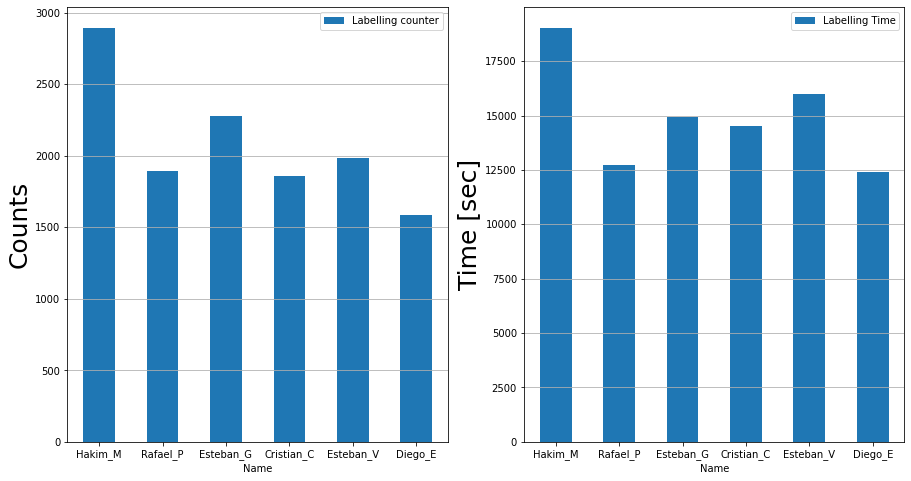

In [45]:
df = labeller_df(labellers)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

axes[0].set_ylabel("Counts", fontsize=25)
df.plot.bar(x = "Name", y = "Labelling counter", ax = axes[0], rot=0).grid("on", axis ="y")

axes[1].set_ylabel("Time [sec]", fontsize=25)
df.plot.bar(x = "Name", y = "Labelling Time", ax = axes[1], rot=0).grid("on", axis ="y")

In [9]:
station_df(labellers)

,Labeller,Station,Station Time,Total Station counter,Events names
0,Hakim_M,capta_002,11783.158841,1632,"[dog, car_moving, wind, impact, crowd, talk, t..."
1,Hakim_M,capta_004,4812.188041,784,"[dog, car_moving, wind, impact, crowd, talk, t..."
2,Hakim_M,capta_003,1478.683751,172,"[dog, car_moving, wind, impact, crowd, talk, t..."
3,Hakim_M,campus_miraflores,0.000000,0,"[dog, car_moving, wind, impact, crowd, talk, t..."
4,Hakim_M,control_acustico,960.595061,307,"[dog, car_moving, wind, impact, crowd, talk, t..."
5,Rafael_P,capta_002,8867.370927,1186,"[dog, car_moving, wind, impact, crowd, talk, t..."
6,Rafael_P,capta_004,1608.281305,332,"[dog, car_moving, wind, impact, crowd, talk, t..."
7,Rafael_P,capta_003,1605.413697,276,"[dog, car_moving, wind, impact, crowd, talk, t..."
8,Rafael_P,campus_miraflores,0.000000,0,"[dog, car_moving, wind, impact, crowd, talk, t..."
9,Rafael_P,control_acustico,654.072083,102,"[dog, car_moving, wind, impact, crowd, talk, t..."


In [10]:
df = station_df(labellers)
a = "Labeller"
df.loc[0]

Labeller                                                           Hakim_M
Station                                                          capta_002
Station Time                                                  11783.158841
Total Station counter                                                 1632
Events names             [dog, car_moving, wind, impact, crowd, talk, t...
Name: 0, dtype: object

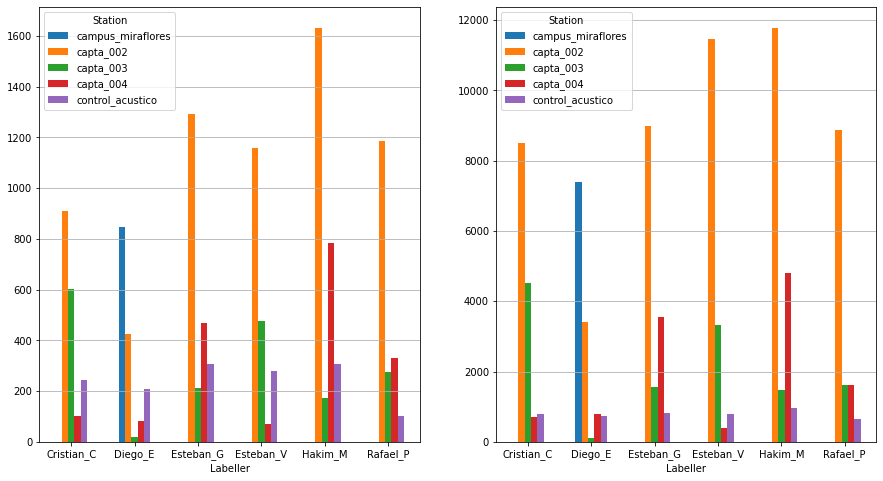

In [11]:
df = station_df(labellers)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

df.pivot_table(index = "Labeller", columns = "Station", values = "Total Station counter").plot.bar(ax = axes[0], rot=0).grid("on", axis ="y")
df.pivot_table(index = "Labeller", columns = "Station", values = "Station Time").plot.bar(ax = axes[1], rot=0).grid("on", axis ="y")

In [12]:
df = station_df(labellers).groupby(["Station"]).agg(sum)
df

C:\Users\Joaquin\AppData\Local\Temp\ipykernel_3096\251782361.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = station_df(labellers).groupby(["Station"]).agg(sum)


,Station Time,Total Station counter
Station,,
campus_miraflores,7404.266901,846
capta_002,53014.951978,6603
capta_003,12591.185389,1760
capta_004,11873.929589,1844
control_acustico,4738.531009,1447


C:\Users\Joaquin\AppData\Local\Temp\ipykernel_3096\366507841.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = station_df(labellers).groupby(["Station"]).agg(sum)


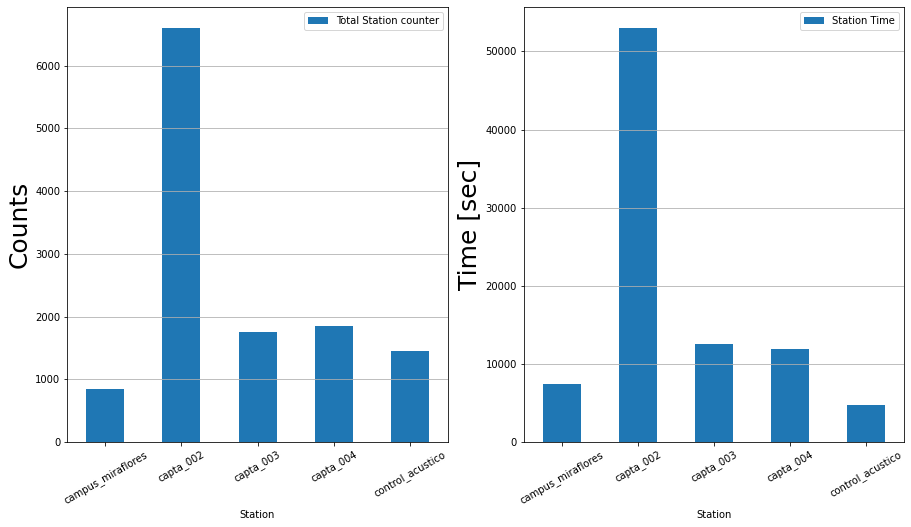

In [46]:
df = station_df(labellers).groupby(["Station"]).agg(sum)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

axes[0].set_ylabel("Counts", fontsize=25)
df.pivot_table(index = "Station", values = "Total Station counter").plot.bar(ax = axes[0], rot=30).grid("on", axis ="y")

axes[1].set_ylabel("Time [sec]", fontsize=25)
df.pivot_table(index = "Station", values = "Station Time").plot.bar(ax = axes[1], rot=30).grid("on", axis ="y")

In [14]:
events_df(labellers)

,Labeller,Station,Event,Acumulated event time,Event counter
0,Hakim_M,capta_002,dog,1372.455802,683
1,Hakim_M,capta_002,car_moving,2644.590446,182
2,Hakim_M,capta_002,wind,2506.695722,71
3,Hakim_M,capta_002,impact,147.573952,55
4,Hakim_M,capta_002,crowd,42.410526,10
...,...,...,...,...,...
835,Diego_E,control_acustico,drilling,0.000000,0
836,Diego_E,control_acustico,water,0.000000,0
837,Diego_E,control_acustico,airborne,0.000000,0
838,Diego_E,control_acustico,bus_idling,0.000000,0


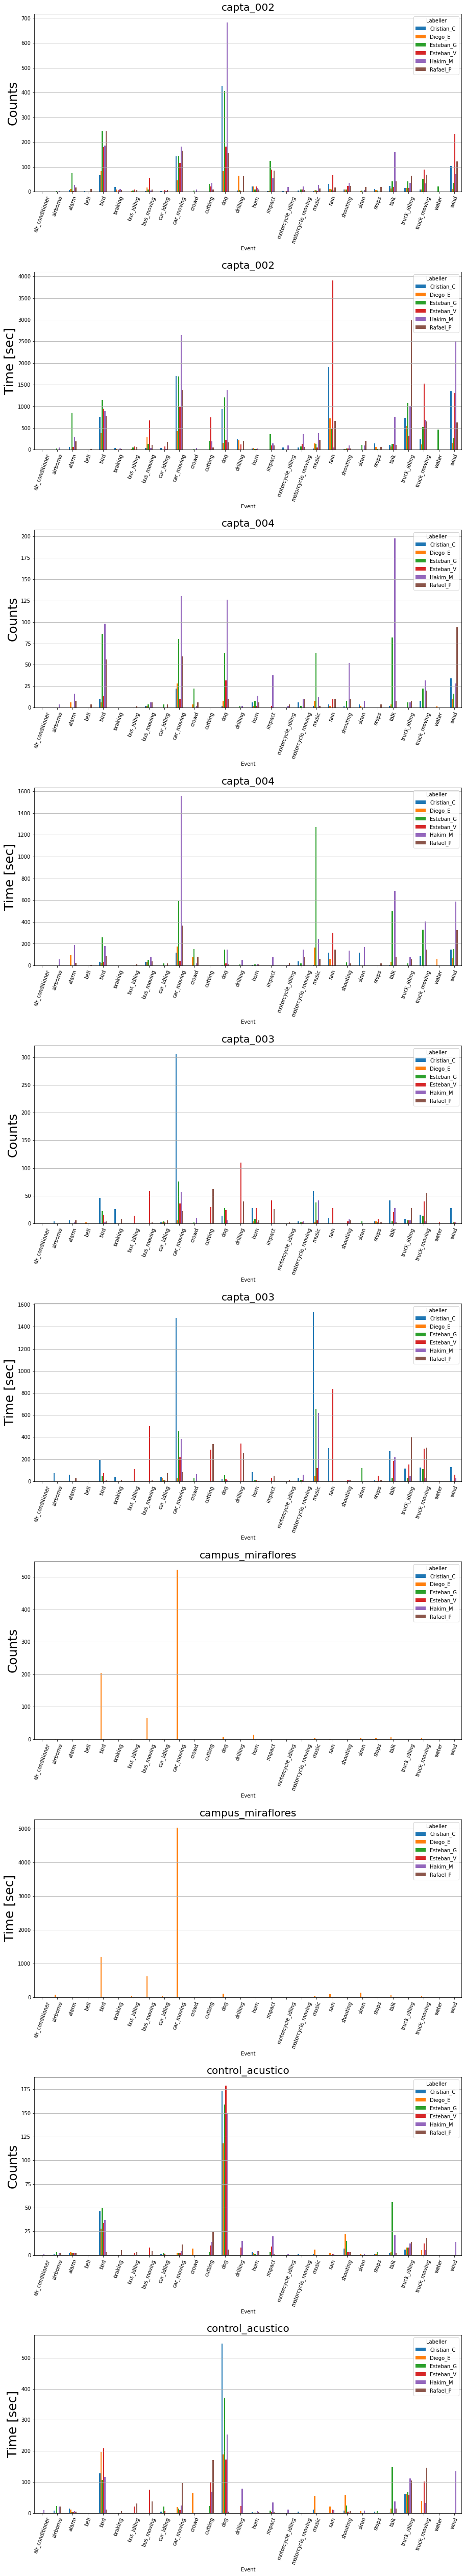

In [49]:
df = events_df(labellers)
df, st = events_station_splitter(df)

n = len(st)

fig, axes = plt.subplots(nrows = n*2, ncols = 1, figsize = (15, 9*n*2))

plt.subplots_adjust(hspace=0.45)

for i in range(n):
    odd = 2*i+1
    pair = 2*i
    
    axes[pair].set_title(st[i], fontdict={"fontsize": 20, "fontweight": "medium"})
    axes[pair].set_ylabel("Counts", fontsize=25)
    df[st[i]].pivot_table(index = "Event", columns = "Labeller", values = "Event counter").plot.bar(ax = axes[pair], rot = 70).grid("on", axis ="y")
    
    
    axes[odd].set_title(st[i], fontdict={"fontsize": 20, "fontweight": "medium"})
    axes[odd].set_ylabel("Time [sec]", fontsize=25)
    df[st[i]].pivot_table(index = "Event", columns = "Labeller", values = "Acumulated event time").plot.bar(ax = axes[odd], rot = 70).grid("on", axis ="y")

In [16]:
events_compressed_df(labellers)

Acumulated event time  Event counter
Station           Event                                                
campus_miraflores air_conditioner               0.000000              0
                  airborne                     72.390244              2
                  alarm                         0.000000              0
                  bell                          0.000000              0
                  bird                       1198.966104            204
...                                                  ...            ...
control_acustico  talk                        214.855232             84
                  truck_idling                462.327392             56
                  truck_moving                318.995913             40
                  water                         0.000000              0
                  wind                        133.818985             14

[140 rows x 2 columns]

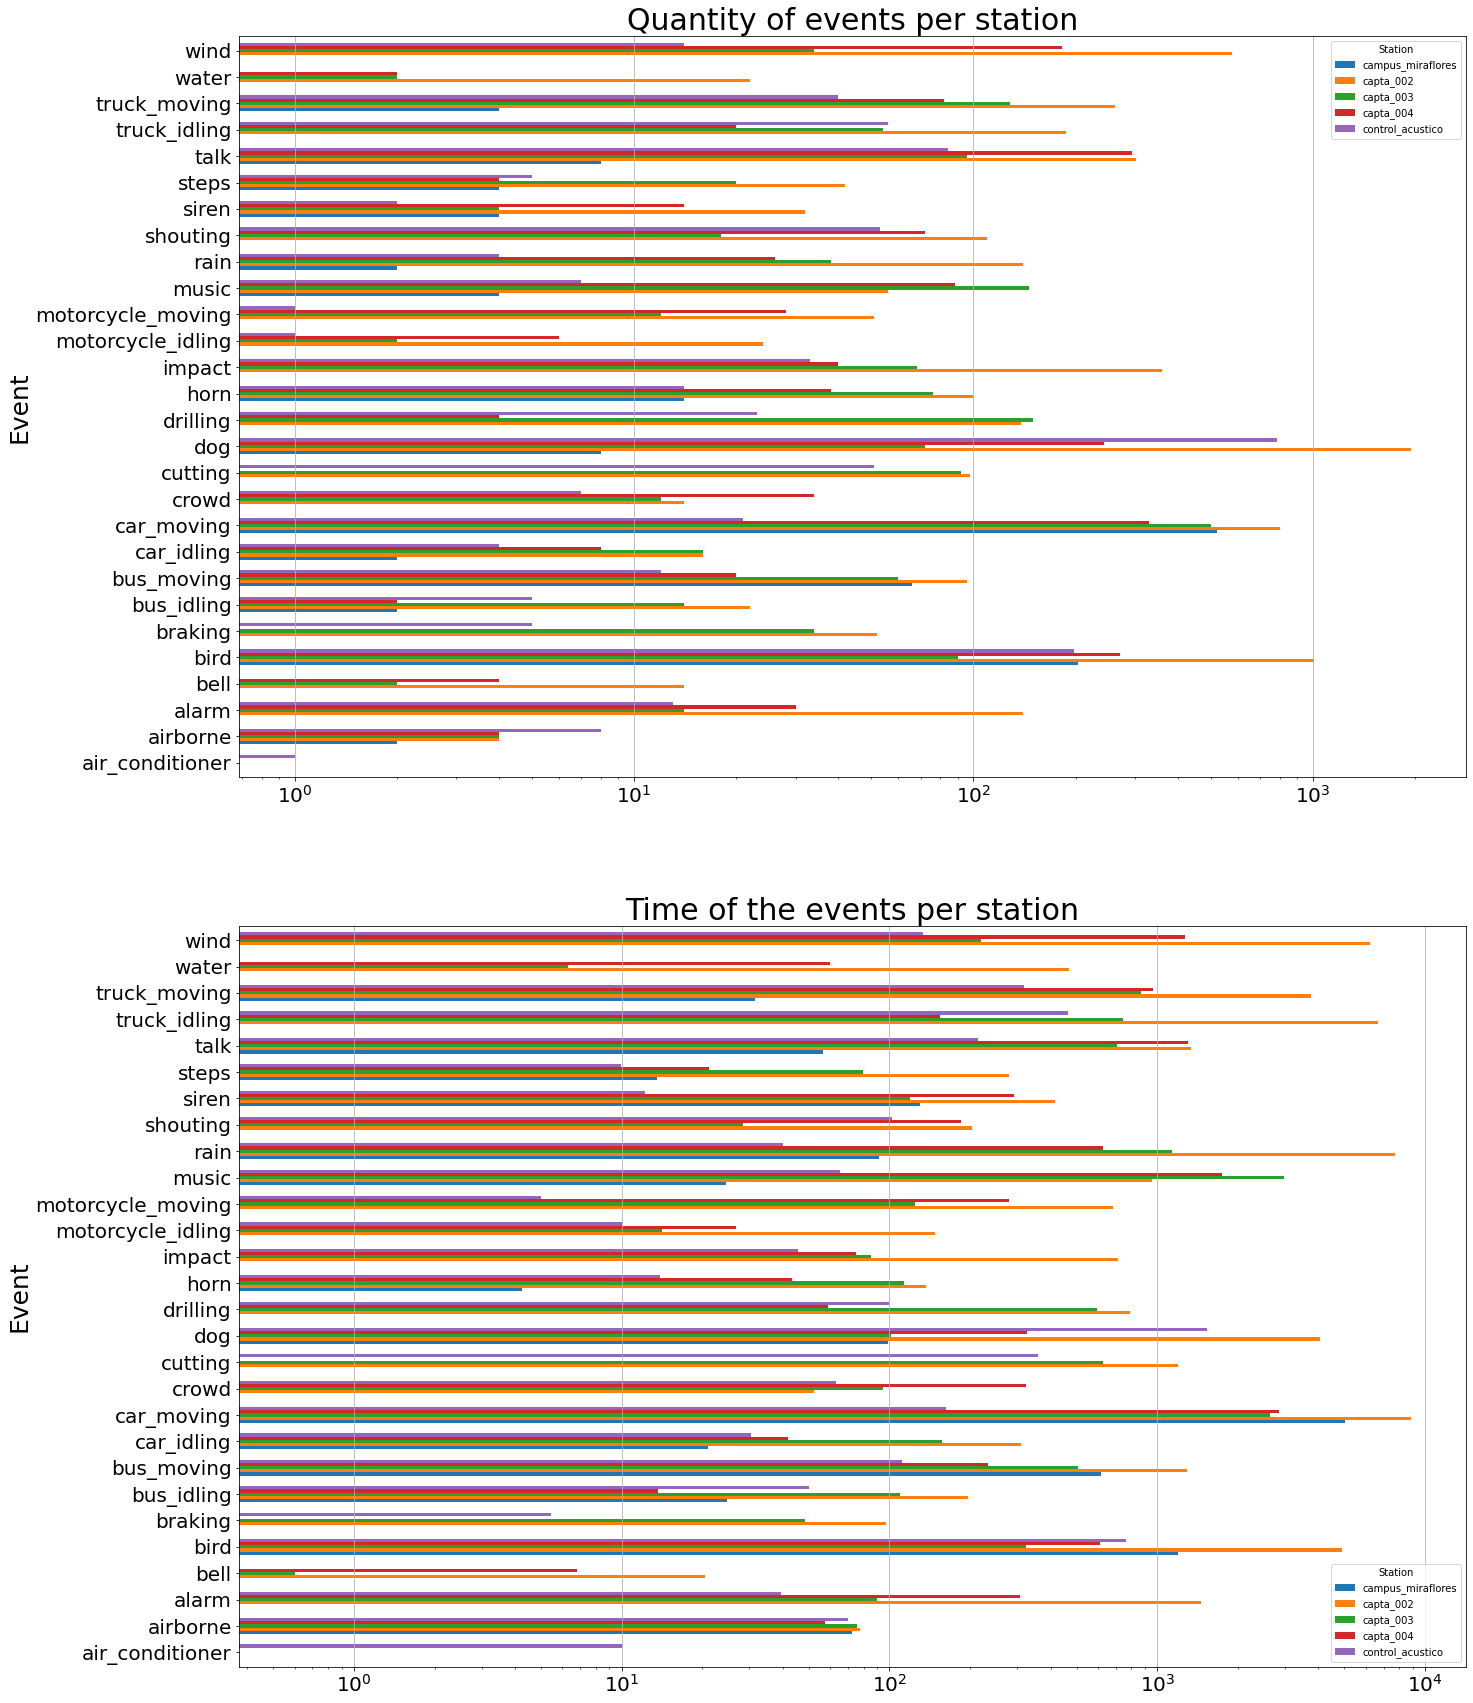

In [17]:
df = events_compressed_df(labellers)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (22, 30))

plt.setp(axes[0].get_xticklabels(), fontsize=20)
plt.setp(axes[0].get_yticklabels(), fontsize=20)
axes[0].set_title("Quantity of events per station", fontdict={"fontsize": 30, "fontweight": "medium"})
axes[0].set_ylabel("", fontsize=25)


plt.setp(axes[1].get_xticklabels(), fontsize=20)
plt.setp(axes[1].get_yticklabels(), fontsize=20)
axes[1].set_title("Time of the events per station", fontdict={"fontsize": 30, "fontweight": "medium"})
axes[1].set_ylabel("", fontsize=25)



df.pivot_table(index = "Event", columns = "Station", values = "Event counter").plot.barh(ax = axes[0], logx=True, width=0.6).grid("on", axis ="x")
df.pivot_table(index = "Event", columns = "Station", values = "Acumulated event time").plot.barh(ax = axes[1], logx=True, width=0.6).grid("on", axis ="x")